<a href="https://colab.research.google.com/github/Mohamedtahaahmedtaha/Task/blob/main/task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing required librares

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import glob

In [3]:
base_path ='/content/drive/MyDrive/ task data'


In [4]:
obf_path = os.path.join(base_path, 'obfuscated')
non_obf_path = os.path.join(base_path, 'non-obfuscated')

Reading Data

In [5]:
def read_scripts_from_folder(folder_path, label):
    data = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
                data.append((content, label))
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return data

obf_data = read_scripts_from_folder(obf_path, 1)
non_obf_data = read_scripts_from_folder(non_obf_path, 0)

all_data = obf_data + non_obf_data
data = pd.DataFrame(all_data, columns=['script', 'label'])

data.head()

,script,label
0, ( n e w - O b J E C T     i o . c o M P r E ...,1
1,"& (   $ e n V : c O m S p e c [ 4 , 1 5 , 2 5 ...",1
2,F u n c t i o n   l i s T ` - ` N a v r E M O ...,1
3, ( ( ' F u ' + ' n c t i o n   L i s t - N A ...,1
4,(   n E w - O B j e c t     S Y s t E M . i O ...,1


**Data preprocceing**

In [6]:
data.shape

(990, 2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   script  990 non-null    object
 1   label   990 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.6+ KB


No missing values

In [8]:
data.isna().sum()

,0
script,0
label,0


**Feature Engineering**

To help the model distinguish between obfuscated and non-obfuscated PowerShell scripts, I extracted a set of handcrafted features based on code structure, randomness, and known malicious patterns.

Length: Obfuscated scripts are usually longer due to encoding and added noise.

Special Characters Count: Obfuscated code tends to use more symbols like @, %, !, etc.

Uppercase Letters: Irregular use of uppercase is often a sign of obfuscation.

Entropy: Measures randomness — higher entropy usually means encoding.

Base64 Strings: Many obfuscated scripts include base64-encoded payloads.

Dynamic Execution (iex): Presence of iex or similar commands is a strong red flag.

Token Count & Average Token Length: Gives an idea of structure; obfuscated code often has long or meaningless tokens.

Concatenation Ops: + or . are used to build payloads dynamically and avoid detection.

Encoding-related Commands: Detects usage of functions like FromBase64String, Decode, etc.

Suspicious Keywords: Words like download, bypass, hidden are common in malicious scripts.

These features are lightweight, explainable, and designed to highlight patterns commonly used in real-world obfuscation techniques.

In [9]:
import re
def calculate_entropy(s):
    prob = [float(s.count(c)) / len(s) for c in dict.fromkeys(list(s))]
    entropy = - sum([p * np.log2(p) for p in prob])
    return entropy


In [10]:
def is_base64(s):
    return bool(re.fullmatch(r'[A-Za-z0-9+/=]{20,}', s))


In [11]:
suspicious_keywords = [
    'bypass', 'hidden', 'invoke', 'iex', 'download', 'http', 'base64',
    'FromBase64String', 'Add-Type', 'Compression', 'shellcode', 'payload'
]

In [12]:
def extract_features(data):
    data['length'] = data['script'].apply(len)
    data['num_special_chars'] = data['script'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)))
    data['num_uppercase'] = data['script'].apply(lambda x: sum(1 for c in x if c.isupper()))
    data['entropy'] = data['script'].apply(calculate_entropy)
    data['num_base64_strings'] = data['script'].apply(lambda x: sum(1 for token in x.split() if is_base64(token)))
    data['has_ie'] = data['script'].apply(lambda x: int(bool(re.search(r'\b(iex|invoke-expression)\b', x, re.IGNORECASE))))
    data['num_tokens'] = data['script'].apply(lambda x: len(x.split()))
    data['avg_token_length'] = data['script'].apply(lambda x: np.mean([len(t) for t in x.split()]) if x.split() else 0)
    data['num_concat_ops'] = data['script'].apply(lambda x: x.count('+') + x.count('.'))
    data['num_encoded_cmds'] = data['script'].apply(lambda x: sum(x.lower().count(cmd.lower()) for cmd in ['FromBase64String', 'Decode', 'Uncompress']))
    data['num_suspicious_words'] = data['script'].apply(
        lambda x: sum(1 for word in suspicious_keywords if word.lower() in x.lower())
    )

    return data

our final dataset

In [13]:
data = extract_features(data)
data.head()

,script,label,length,num_special_chars,num_uppercase,entropy,num_base64_strings,has_ie,num_tokens,avg_token_length,num_concat_ops,num_encoded_cmds,num_suspicious_words
0, ( n e w - O b J E C T     i o . c o M P r E ...,1,2964,1577,608,4.063013,0,0,23,127.869565,29,0,0
1,"& (   $ e n V : c O m S p e c [ 4 , 1 5 , 2 5 ...",1,10832,6043,555,3.121414,0,0,2152,4.033922,133,0,0
2,F u n c t i o n   l i s T ` - ` N a v r E M O ...,1,13942,9288,586,3.299632,0,0,2193,5.357957,126,0,0
3, ( ( ' F u ' + ' n c t i o n   L i s t - N A ...,1,7356,4194,404,3.195261,0,0,1339,4.493652,119,0,0
4,(   n E w - O B j e c t     S Y s t E M . i O ...,1,2484,1320,472,4.058682,0,0,21,117.333333,27,0,0


Generates a full EDA report with statistics, correlations, and warnings about the data.


In [14]:
!pip install ydata-profiling

In [ ]:
from ydata_profiling import ProfileReport

profile= ProfileReport(data)
profile.to_file('file.html')

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


duplicated values

In [ ]:
data.duplicated().value_counts()

Manual EDA to focus on some features

In [ ]:
data.drop_duplicates(inplace=True)
data.shape

497 non obfuscated and 486 obfuscated

In [ ]:
value_counts = data["label"].value_counts().reset_index()
value_counts.columns = ["label", "count"]
fig = px.bar(value_counts, x="label", y="count", title="Value Counts for label",color="label",)
fig.update_layout(
    title_font_size=24,
    font=dict(size=16),
    width=800,
    height=500,
    showlegend=False
)

fig.show()

This histogram shows the distribution of entropy values for both obfuscated (black) and non-obfuscated (pink) PowerShell scripts.

Entropy measures the randomness of a script. Higher entropy typically suggests encoding or obfuscation.

From the plot, we can see that non-obfuscated scripts have higher entropy (right side),

while obfuscated ones cluster around lower entropy values (left/middle), which may indicate structured obfuscation patterns.
This feature could help the model distinguish between the two classes
**Observation**: Obfuscated scripts tend to have lower entropy values, while clean scripts show higher entropy.  
This suggests that obfuscators may use structured patterns that reduce randomness rather than increase it.

In [ ]:
fig = px.histogram(data, x="entropy", color="label", color_discrete_map={
                       0: 'pink',
                       1: 'black'
                   },
                   nbins=50,
                   labels={"label": "Obfuscated"},
                   title="Distribution of Entropy by Script Type")
fig.update_layout(bargap=0.1)
fig.show()

 Obfuscated scripts generally have a much higher count of special characters, with noticeable outliers.
This supports the idea that obfuscation techniques often rely on symbol-heavy patterns and encoding.

In [ ]:
fig = px.box(data, x="label", y="num_special_chars",
             labels={"label": "Obfuscated", "num_special_chars": "Special Characters"},
             title="Special Characters Count by Obfuscation", color='label')
fig.show()

Obfuscated scripts are generally longer, but with moderate entropy.  
This pattern may reflect structured obfuscation techniques such as base64 padding or encoded payloads,
while clean scripts, though shorter, often exhibit higher randomness.

In [ ]:
fig = px.scatter(data, x="length", y="entropy", color="label",
                 labels={"label": "Obfuscated"},
                 title="Script Length vs Entropy")
fig.show()

correlation

In [ ]:
import plotly.figure_factory as ff

corr_df = data.drop(columns=['script']).corr()

annotations = np.array([[f"{val:.3f}" for val in row] for row in corr_df.values])

fig = ff.create_annotated_heatmap(
    z=corr_df.values,
    x=corr_df.columns.tolist(),
    y=corr_df.columns.tolist(),
    annotation_text=annotations,
    colorscale='YlGnBu'
)

fig.update_layout(
    title="Feature Correlation Heatmap (3 Decimal Places)",
    width=1000,
    height=1000,
    margin=dict(t=160)  # t = top margin

)

fig.show()

**Modeling**

In [ ]:
data.drop(columns=['script'],inplace=True)
X=data.drop('label',axis=1)
y=data['label']

Feature selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
ex=ExtraTreesClassifier()
ex.fit(X,y)

In [ ]:
feat = pd.Series(ex.feature_importances_, index=X.columns)
top_feat = feat.nlargest(10).sort_values()
df_feat = top_feat.reset_index()
df_feat.columns = ['Feature', 'Importance']

fig = px.bar(
    df_feat,
    x="Importance",
    y="Feature",
    orientation='h',
    color_discrete_sequence=['red'],
    title="Top 10 Feature Importances"
)

fig.update_layout(
    height=600,
    width=1000,
    yaxis=dict(tickfont=dict(size=14)),
    xaxis=dict(title='Importance'),
    margin=dict(l=100, r=20, t=80, b=40)
)

fig.show()

Splitting data 80% training, 20% testing

In [ ]:
from sklearn.model_selection import train_test_split ,cross_val_score,RandomizedSearchCV
X_train ,X_test,y_train ,y_test =train_test_split(X,y,test_size =.2 , random_state=42 , stratify=y)

Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

Import our ML models

In [ ]:
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

In [ ]:
models = {'Logistic Regression': LogisticRegression(),
         'KNN': KNeighborsClassifier(),
         'Decision Tree': DecisionTreeClassifier(),
         'Random Forest': RandomForestClassifier(),
         'Gradient Boosting Classifier':GradientBoostingClassifier(),
         'Support Vector Machine': SVC(),
         'Stochastic Gradien Descent': SGDClassifier(),
         'xgb Classifier': XGBClassifier()}

In [ ]:
def fit_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                            scoring='accuracy',
                                            cv=5
                                            ).mean()

    return model_scores

Random forest classifier won

In [ ]:
model_scores = fit_score(models,X_train,X_test,y_train,y_test)

model_scores

In [ ]:
models = pd.DataFrame(model_scores, index=["accuracy"])
models.T.plot.bar(color="blue")

Hyperparameters tuning

In [ ]:
np.random.seed(42)
params = {
    'n_estimators': [100, 200, 300,400],
    'max_depth': [None, 10, 20, 30,40],
    'min_samples_split': [2, 5, 10,15],
    'min_samples_leaf': [1, 2, 4,5],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [ ]:
rf = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=params,
                                cv=5,
                                n_iter=100,
                                verbose=1,
                              refit=True,
                                n_jobs=-1
                               )

rf.fit(X_train, y_train)

rf.best_params_

In [35]:
rf.best_estimator_

RandomForestClassifier(max_depth=40, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=400)

In [36]:
rf.best_score_

np.float64(0.9694831895509152)

In [37]:
model = RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=400)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

95 true positive, 82 true negative, 15 false positive, 5 false negative,

<Axes: >

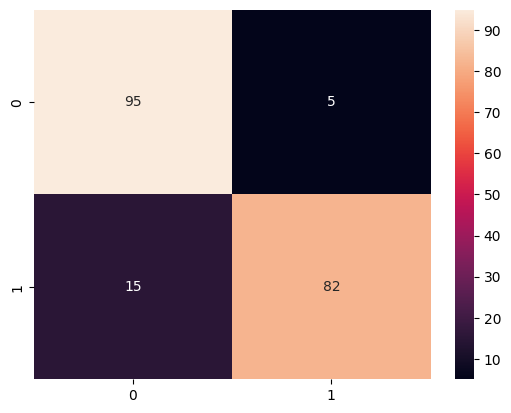

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)) , annot=True)

metrics

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       100
           1       0.94      0.85      0.89        97

    accuracy                           0.90       197
   macro avg       0.90      0.90      0.90       197
weighted avg       0.90      0.90      0.90       197



DL

In [40]:
from tensorflow import keras
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [41]:
Model=keras.Sequential([keras.layers.Dense(64,activation='relu'),
                        keras.layers.Dense(32,activation='relu')
                        ,keras.layers.Dense(16,activation='relu'),
                           keras.layers.Dense(1,activation='sigmoid')])

In [42]:
Model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
history=Model.fit(X_train,y_train,epochs=50,batch_size=32,validation_split=0.2,callbacks=[callback],verbose=1)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.7007 - loss: 0.6971 - val_acc: 0.9367 - val_loss: 0.6378
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9618 - loss: 0.6066 - val_acc: 0.9367 - val_loss: 0.5260
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9595 - loss: 0.4617 - val_acc: 0.9367 - val_loss: 0.3738
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9735 - loss: 0.2929 - val_acc: 0.9367 - val_loss: 0.2710
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9694 - loss: 0.1792 - val_acc: 0.9430 - val_loss: 0.2495
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9546 - loss: 0.1645 - val_acc: 0.9430 - val_loss: 0.2522
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9640 - loss: 0.1364 - val_acc: 0.9430 - val_loss: 0.2502
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9687 - loss: 0.1255 - val_acc: 0.9430 - val_loss: 0.2437
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9480 - los

Overfiiting

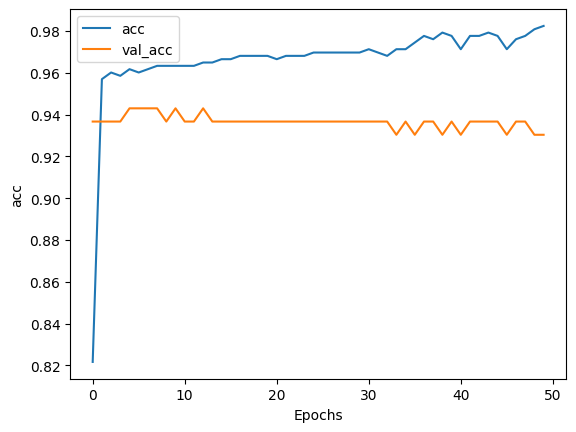

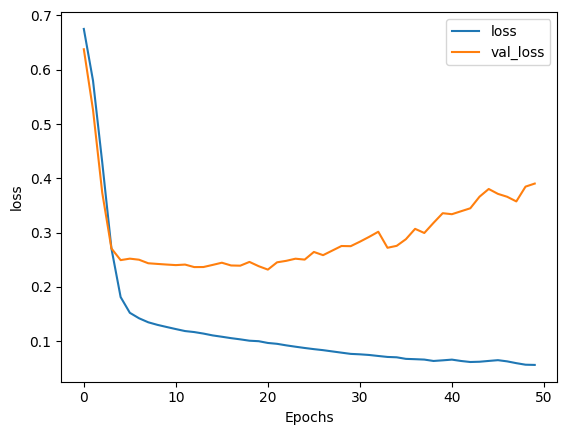

In [43]:
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [44]:
y_pred_deep=Model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


<Axes: >

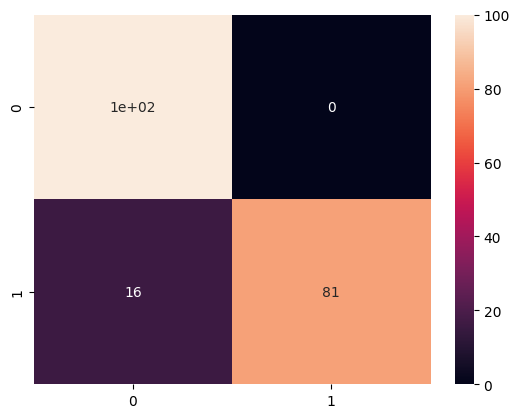

In [45]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred_deep.round())) , annot=True)

In [46]:
print(classification_report(y_test, y_pred_deep.round()))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       100
           1       1.00      0.84      0.91        97

    accuracy                           0.92       197
   macro avg       0.93      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197



In [47]:
from tensorflow.keras import layers, models, regularizers, callbacks
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])

In [48]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [49]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5984 - loss: 0.8242 - val_accuracy: 0.8544 - val_loss: 0.6620
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7502 - loss: 0.5803 - val_accuracy: 0.9304 - val_loss: 0.6083
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7990 - loss: 0.5617 - val_accuracy: 0.9367 - val_loss: 0.5606
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8456 - loss: 0.4369 - val_accuracy: 0.9430 - val_loss: 0.5116
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9022 - loss: 0.3740 - val_accuracy: 0.9430 - val_loss: 0.4677
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9034 - loss: 0.3503 - val_accuracy: 0.9430 - val_loss: 0.4305
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8866 - loss: 0.3762 - val_accuracy: 0.9430 - val_loss: 0.3979
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9072 - loss: 0.3128 - val_accuracy: 0.9430 - v

KeyboardInterrupt: 

Our final, optimized and perfect model

In [ ]:
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
y_pred_deep=model.predict(X_test)

In [ ]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred_deep.round())) , annot=True)

In [ ]:
print(classification_report(y_test, y_pred_deep.round()))